In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from mymodule.DatabaseConnection import CRUD
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import importlib
import mymodule.DatabaseConnection  # first import
importlib.reload(mymodule.DatabaseConnection) 

<module 'mymodule.DatabaseConnection' from 'c:\\Projects\\Market\\mymodule\\DatabaseConnection.py'>

In [3]:
lo_stockdailyupdate = CRUD('stockdailyupdate',schema=None)

In [4]:
df_stocks = lo_stockdailyupdate.Read()

In [5]:
df_stocks.shape

(11418032, 9)

In [6]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418032 entries, 0 to 11418031
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   StockExchange  object 
 1   Symbol         object 
 2   Date           object 
 3   open           float64
 4   high           float64
 5   low            float64
 6   close          float64
 7   volume         int64  
 8   delivery       int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 784.0+ MB


In [7]:
df_stocks.head(5)

,StockExchange,Symbol,Date,open,high,low,close,volume,delivery
0,BSE,500008,2007-09-19,41.1154,42.0574,40.0072,40.4782,543279,0
1,BSE,500008,2007-09-20,40.6306,41.1708,39.6470,39.9933,111498,0
2,BSE,500008,2007-09-21,40.3674,40.9353,39.6886,39.8271,139758,0
3,BSE,500008,2007-09-24,40.0349,40.4089,39.0929,39.3699,66939,0
4,BSE,500008,2007-09-25,39.2037,39.6470,38.5803,38.6080,84693,0


In [8]:
df_stocks.isnull().sum()

StockExchange    0
Symbol           0
Date             0
open             0
high             0
low              0
close            0
volume           0
delivery         0
dtype: int64

In [9]:
# Filter for one stock (or loop for multiple later)
df = df_stocks[df_stocks['Symbol'] == 'VEDL'].copy()

# Sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [10]:
df.shape

(6241, 9)

In [11]:
df["20DMA"] = df["close"].rolling(20).mean()
df["50DMA"] = df["close"].rolling(50).mean()
df["100DMA"] = df["close"].rolling(100).mean()
df["200DMA"] = df["close"].rolling(200).mean()

In [12]:
df.shape

(6241, 13)

In [13]:
df.columns

Index(['StockExchange', 'Symbol', 'Date', 'open', 'high', 'low', 'close',
       'volume', 'delivery', '20DMA', '50DMA', '100DMA', '200DMA'],
      dtype='object')

In [14]:
features = ['open', 'high', 'low', 'close', 'volume'] #, '20DMA', '50DMA', '100DMA', '200DMA'] #, 'RSI', ]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

In [15]:
scaled_df

,open,high,low,close,volume
11037269,0.000073,0.000072,0.000058,0.000071,0.000310
11037270,0.000071,0.000100,0.000058,0.000090,0.001152
11037271,0.000104,0.000133,0.000080,0.000082,0.000503
11037272,0.000054,0.000100,0.000054,0.000090,0.000625
11037273,0.000078,0.000105,0.000079,0.000107,0.000827
...,...,...,...,...,...
11043505,0.943439,0.940215,0.941979,0.934921,0.031113
11043506,0.938608,0.946474,0.945415,0.952867,0.022974
11043507,0.961914,0.965437,0.965455,0.974875,0.023332
11043508,0.982378,0.978048,0.986926,0.980164,0.017935


In [16]:
lookback = 60
X, y = [], []

for i in range(lookback, len(scaled_df)):
    X.append(scaled_df.iloc[i-lookback:i].values)
    y.append(scaled_df.iloc[i]['close'])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # (samples, timesteps=60, features)
print("y shape:", y.shape)  # (samples,)

X shape: (6181, 60, 5)
y shape: (6181,)


In [17]:
X[0][59]

array([0.0006341 , 0.00064489, 0.00060713, 0.00061344, 0.00535487])

In [18]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class PositionalEncoding(Layer):
    def __init__(self, sequence_len, d_model):
        super().__init__()
        self.sequence_len = sequence_len
        self.d_model = d_model

    def call(self, x):
        position = tf.range(self.sequence_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(
            tf.range(0, self.d_model, 2, dtype=tf.float32) *
            (-tf.math.log(10000.0) / self.d_model)
        )

        pe = tf.zeros((self.sequence_len, self.d_model))
        pe_even = tf.sin(position * div_term)
        pe_odd = tf.cos(position * div_term)

        pe = tf.reshape(
            tf.stack([pe_even, pe_odd], axis=2),
            (self.sequence_len, self.d_model)
        )

        pe = pe[tf.newaxis, ...]
        return x + pe[:, :tf.shape(x)[1], :]


In [20]:
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention
)

class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D

sequence_length = X_train.shape[1]
feature_dim = X_train.shape[2]
embed_dim = 64
num_heads = 4
ff_dim = 128

inputs = Input(shape=(sequence_length, feature_dim))
x = Dense(embed_dim)(inputs)
x = PositionalEncoding(sequence_length, embed_dim)(x)
x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)
x = Dropout(0.2)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(16, activation="relu")(x)
outputs = Dense(1)(x)  # Regression output

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_1           │ (None, 60, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 60, 64)         │        83,200 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,641 (330.63 KB)

 Trainable params: 84,641 (330.63 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0280 - val_loss: 0.0024
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0031 - val_loss: 6.4660e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0011 - val_loss: 4.7185e-04
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.8733e-04 - val_loss: 0.0020
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 6.4554e-04 - val_loss: 0.0018
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 4.9981e-04 - val_loss: 0.0029
Epoch 12/1

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


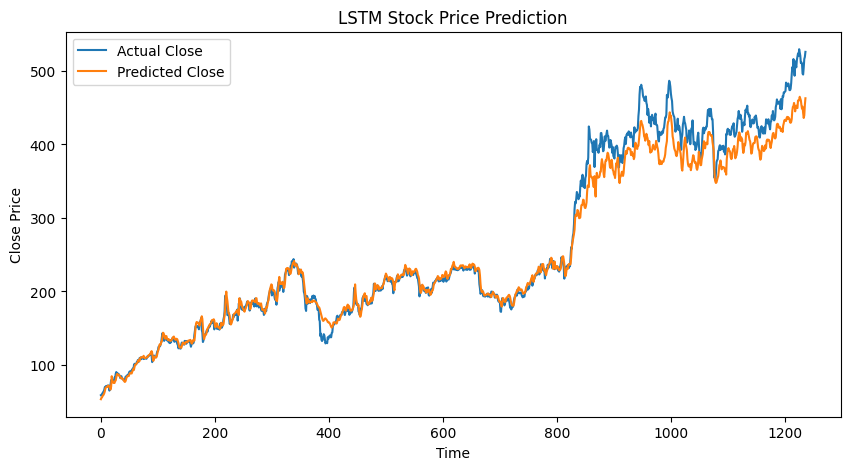

In [25]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)
#accuracy = accuracy_score(y_test, y_pred)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 455.2349
RMSE: 21.3362
MAE : 13.9929
R²  : 0.9696


In [27]:
y_pred

array([[0.1005018 ],
       [0.10419907],
       [0.10526075],
       ...,
       [0.830037  ],
       [0.85661054],
       [0.87398636]], shape=(1237, 1), dtype=float32)

In [28]:
y_test

array([0.11072582, 0.11146238, 0.11385662, ..., 0.97487497, 0.98016445,
       0.99319924], shape=(1237,))

In [29]:
y_test_inv

array([ 58.8604,  59.2503,  60.5177, ..., 516.3   , 519.1   , 526.    ],
      shape=(1237,))

In [30]:
y_pred_inv

array([[ 53.44828813],
       [ 55.40545085],
       [ 55.96745282],
       ...,
       [439.62964288],
       [453.69641472],
       [462.89435384]], shape=(1237, 1))